In [62]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.dates as mdates
from matplotlib import rcParams
from statsmodels.tsa.stattools import acf,adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from warnings import filterwarnings

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

url = 'https://apis.data.go.kr/1480523/WaterQualityService/getWaterMeasuringList'
key = 'a6TS+sDQ+cPdv92zVxHz2EI1fV2sWy5kXdu9x/+QasyDSIU3105j6dts2lS2dnW7Y/YFXSw32QdOqyagGTCI8Q=='

In [63]:
# 2. 주소에 있던 파라미터 그대로 설정
params = {
    'serviceKey': key,
    'pageNo': '1',
    'numOfRows': '3000',
    'resultType': 'json',
    'ptNoList': '2022A30,2022A10', # 측정소 코드
    'wmyrList': '2021,2022,2023,2024,2025',      # 연도
    'wmodList': '01,02,03,04,05,06,07,08,09,10,11,12'        # 월(01, 02, 03월)
}

try:
    # 3. API 요청
    response = requests.get(url, params=params, verify=True) # https 대응
    
    if response.status_code == 200:
        data = response.json()
        
        # 4. 데이터 추출 (구조: getWaterMeasuringList -> item)
        items = data.get('getWaterMeasuringList', {}).get('item', [])
        
        if items:
            df = pd.DataFrame(items)
            # df.set_index('ROWNO',inplace=True)

            # 5. 주요 수질 항목 한글 이름으로 변경 (보기 좋게)
            rename_map = {
                'PT_NM': '총량지점명',
                'WMCYMD': '일자',
                'ITEM_TEMP': '수온', # 단위 : ℃
                'ITEM_PH': '수소이온농도(ph)',
                'ITEM_EC': '전기전도도(EC)',    # 단위 : μS/㎝
                'ITEM_DOC': '용존산소(DO)', # 단위 : ㎎/L
                'ITEM_BOD': 'BOD',  # 단위 : ㎎/L
                'ITEM_COD': 'COD',  # 단위 : ㎎/L
                'ITEM_SS': '부유물질',  # 단위 : ㎎/L
                'ITEM_TN': '총질소(T-N)',   # 단위 : ㎎/L
                'ITEM_TP': '총인(T-P)', # 단위 : ㎎/L
                'ITEM_TOC': '총유기탄소(TOC)',  # 단위 : ㎎/L
                'ITEM_AMNT': '유량',    # 단위 : ㎥/s
                'ITEM_CLOA': '클로로필-a'
            }
            
            # 2. 필요한 컬럼만 추출하여 새 DF 생성
            waterDF = df[list(rename_map.keys())].copy()
            waterDF.rename(columns=rename_map, inplace=True)

            # 3. 데이터 타입 숫자형으로 변환 (연산 가능하게)
            num_cols = ['수온', '수소이온농도(ph)', '전기전도도(EC)', '용존산소(DO)', 'BOD', 'COD', '부유물질', '총질소(T-N)', '총인(T-P)', '총유기탄소(TOC)', '유량','클로로필-a']
            waterDF[num_cols] = waterDF[num_cols].apply(pd.to_numeric, errors='coerce')

            # # 4. 날짜 데이터 형식 변환 (YYYYMMDD -> datetime)
            waterDF['일자'] = pd.to_datetime(waterDF['일자'], errors='coerce')

            print("--- 분석 준비 완료: 핵심 수질 지표 ---")
            print(waterDF.head())
        else:
            print("응답은 성공했으나 데이터가 없습니다.")
    else:
        print(f"API 요청 실패: {response.status_code}")

except Exception as e:
    print(f"오류 발생: {e}")

--- 분석 준비 완료: 핵심 수질 지표 ---
  총량지점명         일자   수온  수소이온농도(ph)  전기전도도(EC)  용존산소(DO)  BOD  COD  부유물질  \
0    물금 2021-01-04  4.6         7.5      437.0      13.1  1.7  5.1   2.4   
1    물금 2021-01-11  2.8         7.3      461.0      14.3  2.0  5.4   4.0   
2    물금 2021-01-26  5.1         7.2      470.0      15.6  2.1  6.0   7.6   
3    물금 2021-01-18  3.1         7.3      463.0      15.2  2.2  5.9   6.4   
4    물금 2021-02-16  6.6         8.4      451.0      12.1  2.8  6.6  12.4   

   총질소(T-N)  총인(T-P)  총유기탄소(TOC)      유량  클로로필-a  
0     3.223    0.025         3.8  29.555    12.4  
1     3.268    0.031         4.0  28.599    19.4  
2     3.416    0.026         4.6  74.897    47.3  
3     3.327    0.032         4.4  47.190    33.2  
4     3.489    0.027         5.0  72.735    50.4  


In [64]:
waterDF

,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a
0,물금,2021-01-04,4.6,7.5,437.0,13.1,1.7,5.1,2.4,3.223,0.025,3.8,29.555,12.4
1,물금,2021-01-11,2.8,7.3,461.0,14.3,2.0,5.4,4.0,3.268,0.031,4.0,28.599,19.4
2,물금,2021-01-26,5.1,7.2,470.0,15.6,2.1,6.0,7.6,3.416,0.026,4.6,74.897,47.3
3,물금,2021-01-18,3.1,7.3,463.0,15.2,2.2,5.9,6.4,3.327,0.032,4.4,47.190,33.2
4,물금,2021-02-16,6.6,8.4,451.0,12.1,2.8,6.6,12.4,3.489,0.027,5.0,72.735,50.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4
402,금곡,2025-09-09,28.6,8.6,219.0,7.6,1.7,8.6,9.6,1.579,0.059,6.1,340.400,52.6
403,금곡,2025-10-13,23.3,8.4,288.0,9.0,1.6,7.0,7.6,1.858,0.041,3.4,443.810,39.5
404,금곡,2025-10-27,19.0,7.8,192.0,9.5,1.1,6.4,6.4,2.719,0.082,3.2,443.180,20.4


In [65]:
waterDF['일자'].dtype

dtype('<M8[ns]')

In [66]:
waterDF['월'] = waterDF['일자'].dt.month

In [67]:
waterDF['월'].value_counts().sort_index()

월
1     29
2     36
3     31
4     39
5     36
6     39
7     34
8     32
9     37
10    37
11    32
12    24
Name: count, dtype: int64

In [68]:
summerDF = waterDF[waterDF['월'].between(6, 9)].copy()
summerDF

,총량지점명,일자,수온,수소이온농도(ph),전기전도도(EC),용존산소(DO),BOD,COD,부유물질,총질소(T-N),총인(T-P),총유기탄소(TOC),유량,클로로필-a,월
20,물금,2021-06-01,24.3,8.4,295.0,9.2,1.9,6.0,4.0,2.197,0.016,4.2,311.005,24.1,6
21,물금,2021-06-22,26.7,8.7,272.0,9.0,3.0,7.0,6.0,1.717,0.022,4.8,353.580,30.8,6
22,물금,2021-06-14,25.7,8.1,290.0,8.7,1.8,6.6,6.4,1.886,0.047,4.3,130.690,39.4,6
23,물금,2021-06-08,26.9,8.7,291.0,10.0,2.5,7.1,5.6,1.933,0.015,4.5,191.250,25.9,6
24,물금,2021-07-12,26.2,7.2,135.0,7.7,1.1,7.9,30.0,2.310,0.084,5.1,2009.616,12.1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,금곡,2025-08-18,30.7,7.9,166.0,9.0,2.7,6.5,6.0,2.524,0.093,3.9,418.950,27.3,8
399,금곡,2025-09-01,30.4,8.9,188.0,8.9,1.8,8.1,10.0,1.609,0.054,3.4,307.440,38.1,9
400,금곡,2025-09-15,28.8,8.6,275.0,9.7,2.2,8.3,7.2,1.758,0.055,3.9,184.660,48.9,9
401,금곡,2025-09-23,25.4,7.7,285.0,7.8,1.3,6.9,6.4,1.928,0.055,3.6,357.260,17.4,9


In [69]:
# 물금 금곡 분리
summer_mulgum = summerDF[summerDF['총량지점명'].str.contains('물금', na=False)].copy()
summer_geumgok = summerDF[summerDF['총량지점명'].str.contains('금곡', na=False)].copy()

In [70]:
summer_mulgum['월'].value_counts().sort_index()

월
6    20
7    20
8    20
9    21
Name: count, dtype: int64

In [71]:
summer_geumgok['월'].value_counts().sort_index()

월
6    19
7    14
8    12
9    16
Name: count, dtype: int64

In [72]:
# 행 갯수 비교
print('물금 행 개수:', len(summer_mulgum))
print('금곡 행 개수:', len(summer_geumgok))

물금 행 개수: 81
금곡 행 개수: 61


In [73]:
target = '클로로필-a'
corr_cols = ['수온','전기전도도(EC)','용존산소(DO)','BOD','COD','부유물질','총질소(T-N)','총인(T-P)','총유기탄소(TOC)','유량', target]

mulgum_corr = summer_mulgum[corr_cols].dropna().corr(method='spearman')[target].sort_values(ascending=False)
geumgok_corr = summer_geumgok[corr_cols].dropna().corr(method='spearman')[target].sort_values(ascending=False)

print("물금 Spearman 상관(클로로필-a):\n", mulgum_corr)
print("\n금곡 Spearman 상관(클로로필-a):\n", geumgok_corr)


물금 Spearman 상관(클로로필-a):
 클로로필-a        1.000000
BOD           0.623602
COD           0.495038
전기전도도(EC)     0.474684
용존산소(DO)      0.397265
수온            0.350482
총유기탄소(TOC)    0.260629
부유물질          0.047464
총인(T-P)      -0.514591
유량           -0.527660
총질소(T-N)     -0.545711
Name: 클로로필-a, dtype: float64

금곡 Spearman 상관(클로로필-a):
 클로로필-a        1.000000
BOD           0.665436
COD           0.493301
전기전도도(EC)     0.434869
용존산소(DO)      0.421779
수온            0.403589
총유기탄소(TOC)    0.172012
부유물질          0.049759
총질소(T-N)     -0.422339
총인(T-P)      -0.431941
유량           -0.545560
Name: 클로로필-a, dtype: float64


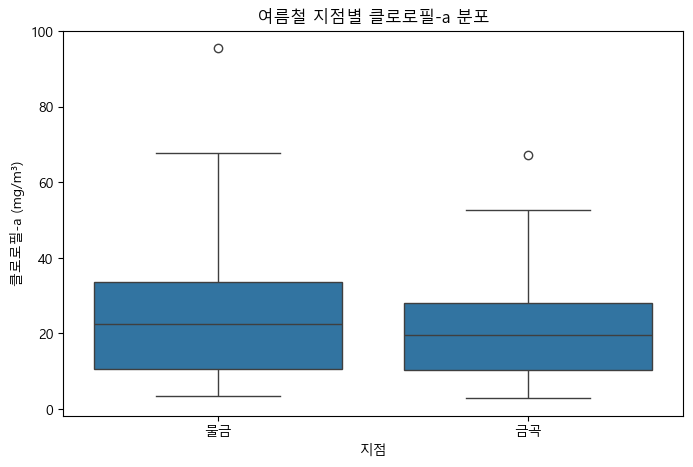

In [74]:
plt.figure(figsize=(8,5))
sb.boxplot(data=summerDF, x='총량지점명', y='클로로필-a')
plt.title('여름철 지점별 클로로필-a 분포')
plt.xlabel('지점')
plt.ylabel('클로로필-a (mg/m³)')
plt.show()


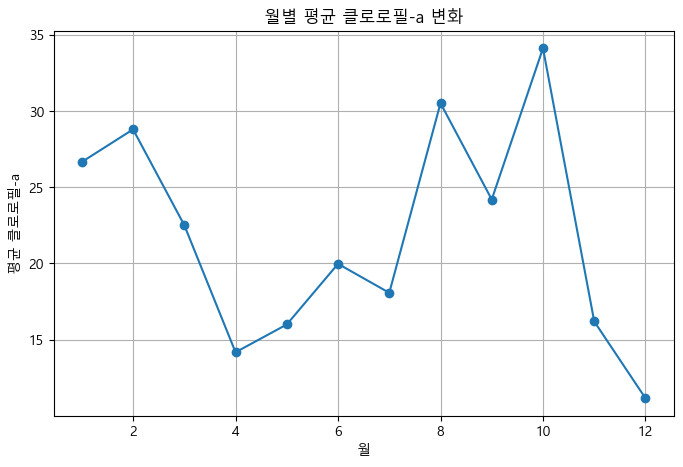

In [75]:
monthly_chla = waterDF.groupby('월')['클로로필-a'].mean()

plt.figure(figsize=(8,5))
monthly_chla.plot(marker='o')
plt.title('월별 평균 클로로필-a 변화')
plt.xlabel('월')
plt.ylabel('평균 클로로필-a')
plt.grid(True)
plt.show()


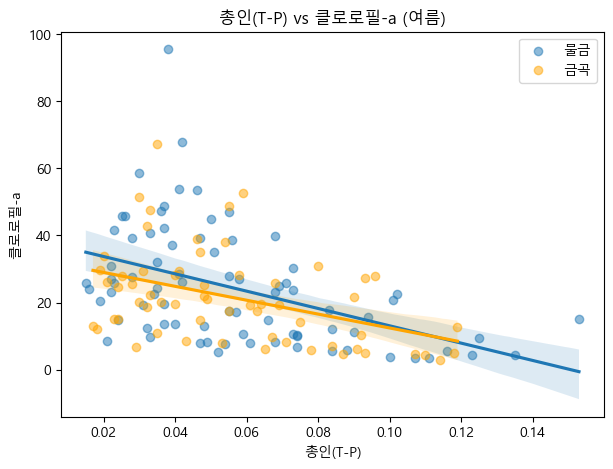

In [76]:
plt.figure(figsize=(7,5))
sb.regplot(
    data=summer_mulgum,
    x='총인(T-P)',
    y='클로로필-a',
    scatter_kws={'alpha':0.5},
    label='물금'
)
sb.regplot(
    data=summer_geumgok,
    x='총인(T-P)',
    y='클로로필-a',
    scatter_kws={'alpha':0.5},
    label='금곡',
    color='orange'
)
plt.legend()
plt.title('총인(T-P) vs 클로로필-a (여름)')
plt.show()


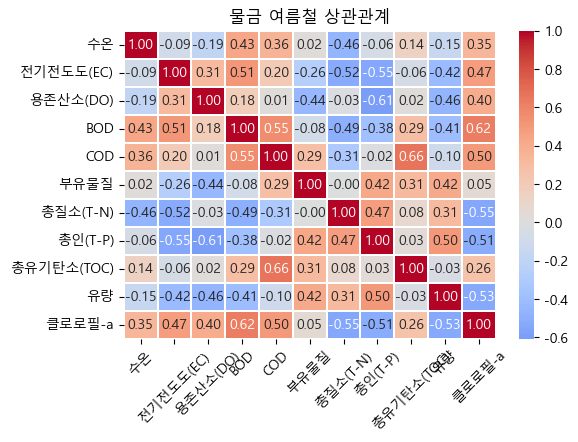

In [79]:
plt.figure(figsize=(6,4))
sb.heatmap(
    summer_mulgum[corr_cols].corr(method='spearman'),
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.3
)
plt.xticks(rotation=45)
plt.title('물금 여름철 상관관계')
plt.show()


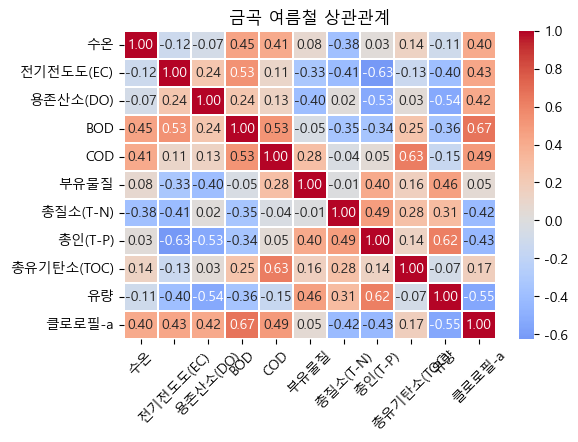

In [80]:
plt.figure(figsize=(6,4))
sb.heatmap(
    summer_geumgok[corr_cols].corr(method='spearman'),
    cmap='coolwarm',
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.3
)
plt.xticks(rotation=45)
plt.title('금곡 여름철 상관관계')
plt.show()